In [26]:
from torchvision import datasets, transforms
import torch

trainset = datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                # transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        ),
    )

# 데이터를 2차원으로 변환하기 위해 각 이미지 벡터화 (32x32x3 -> 3072)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=False)

# 데이터 로드
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지를 numpy 배열로 변환 및 크기 조정 (Bx3x32x32 -> Bx3072)
images = images.numpy()[:1000]

Files already downloaded and verified


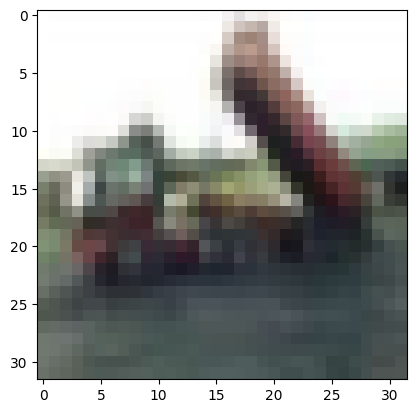

In [6]:
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
from scipy.fftpack import dct, idct


sample = images[2]

plt.imshow(sample.transpose(1, 2, 0))

In [193]:
import numpy as np

# Standard JPEG Quantization Tables (Baseline)
LUMINANCE_QT = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=np.float32)

CHROMINANCE_QT = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
], dtype=np.float32)

def generate_quantization_table(qf: int):
    """
    Generate JPEG quantization tables based on the given quality factor (QF).
    
    :param qf: Quality factor (1-100). Higher means better quality, less compression.
    :return: Tuple of (luminance_qt, chrominance_qt)
    """
    if qf < 1:
        qf = 1
    elif qf > 100:
        qf = 100
    
    # Scale factor S based on QF
    if qf < 50:
        S = 5000 / qf
    else:
        S = 200 - 2 * qf

    # Apply scaling and clip values between 1 and 255
    luminance_qt = np.round((LUMINANCE_QT * S) / 50).clip(1, 255).astype(np.uint8)
    chrominance_qt = np.round((CHROMINANCE_QT * S) / 50).clip(1, 255).astype(np.uint8)

    return luminance_qt, chrominance_qt

# Example usage:
qf = 90  # Set quality factor (1 to 100)
lum_qt, chr_qt = generate_quantization_table(qf)

print("Luminance Quantization Table (QF={}):\n".format(qf), lum_qt)
print("\nChrominance Quantization Table (QF={}):\n".format(qf), chr_qt)


Luminance Quantization Table (QF=90):
 [[ 6  4  4  6 10 16 20 24]
 [ 5  5  6  8 10 23 24 22]
 [ 6  5  6 10 16 23 28 22]
 [ 6  7  9 12 20 35 32 25]
 [ 7  9 15 22 27 44 41 31]
 [10 14 22 26 32 42 45 37]
 [20 26 31 35 41 48 48 40]
 [29 37 38 39 45 40 41 40]]

Chrominance Quantization Table (QF=90):
 [[ 7  7 10 19 40 40 40 40]
 [ 7  8 10 26 40 40 40 40]
 [10 10 22 40 40 40 40 40]
 [19 26 40 40 40 40 40 40]
 [40 40 40 40 40 40 40 40]
 [40 40 40 40 40 40 40 40]
 [40 40 40 40 40 40 40 40]
 [40 40 40 40 40 40 40 40]]


In [5]:
lum_mask = np.load('luminance_mask.npy')
chro_cr_mask = np.load('chrominance_cr_mask.npy')
chro_cb_mask = np.load('chrominance_cb_mask.npy')

In [6]:
import numpy as np
from PIL import Image
import io

def compress_image(img_array, quality=10):
    """
    Compresses a 3x32x32 image using JPEG compression.

    Args:
        img_array (np.ndarray): Input image in shape (3, 32, 32), values in [0,1].
        quality (int): JPEG compression quality (1-100, higher = better quality).

    Returns:
        np.ndarray: Compressed and decompressed image in shape (3, 32, 32), values in [0,1].
    """
    # Convert (3, 32, 32) → (32, 32, 3) and scale [0,1] → [0,255]
    img = (img_array * 255).clip(0, 255).astype(np.uint8)
    img = Image.fromarray(img.transpose(1, 2, 0))  # Convert to PIL Image

    # Save image to memory buffer as JPEG
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=quality)  # JPEG compression

    # Load image back from memory
    buffer.seek(0)
    compressed_img = Image.open(buffer)

    # Convert back to NumPy format (3, 32, 32) and scale [0,255] → [0,1]
    compressed_array = np.array(compressed_img).transpose(2, 0, 1) / 255.0

    return compressed_array

# Example usage:
compressed_sample1 = compress_image(sample, quality=75)

print("Original shape:", sample.shape)
print("Compressed shape:", compressed_sample1.shape)


Original shape: (3, 32, 32)
Compressed shape: (3, 32, 32)


In [ ]:
import numpy as np
import cv2

# JPEG Luminance & Chrominance Quantization Tables for QF = 75
LUMINANCE_QT = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

CHROMINANCE_QT = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

LUMINANCE_QT, CHROMINANCE_QT_1, CHROMINANCE_QT_2 = np.load('../../data/luminance_mask_weak.npy'), np.load('../../data/chrominance_cb_mask_weak.npy'), np.load('../../data/chrominance_cr_mask_weak.npy')

def apply_dct(block):
    """ Apply DCT to an 8x8 block """
    return cv2.dct(block.astype(np.float32) - 128)  # Center around zero

def apply_idct(block):
    """ Apply Inverse DCT to an 8x8 block """
    return cv2.idct(block) + 128  # Reverse centering

def jpeg_compress_manual(img_array):
    """
    Manually compresses a 3x32x32 image using JPEG-like processing.

    Args:
        img_array (np.ndarray): Input image (3, 32, 32) with values in [0,1].

    Returns:
        np.ndarray: Reconstructed image after simulated JPEG compression.
    """
    # Convert to (32, 32, 3) and scale to 0-255
    img = (img_array * 255).clip(0, 255).astype(np.uint8)
    img_ycrcb = cv2.cvtColor(img.transpose(1, 2, 0), cv2.COLOR_RGB2YCrCb)

    # Create an empty array for reconstructed image
    reconstructed = np.zeros_like(img_ycrcb, dtype=np.float32)

    # Process in 8x8 blocks
    for i in range(0, 32, 8):
        for j in range(0, 32, 8):
            for ch, qt in enumerate([LUMINANCE_QT, CHROMINANCE_QT_1, CHROMINANCE_QT_2]):  
                block = img_ycrcb[i:i+8, j:j+8, ch]

                # Apply DCT
                dct_block = apply_dct(block)

                # Quantization (lossy step)
                # quantized = np.round(dct_block / qt)

                # # Dequantization (reconstruction)
                # dequantized = quantized * qt
                dequantized = dct_block * ~qt

                # Inverse DCT
                reconstructed[i:i+8, j:j+8, ch] = apply_idct(dequantized)

    # Clip values and convert back to uint8
    reconstructed = reconstructed.clip(0, 255).astype(np.uint8)

    # Convert YCrCb → RGB
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_YCrCb2RGB)

    # Scale back to [0,1] and return in (3, 32, 32) format
    return reconstructed_rgb.transpose(2, 0, 1) / 255.0

# Example usage
compressed_sample = jpeg_compress_manual(sample)

print("Original shape:", sample.shape)
print("Compressed shape:", compressed_sample.shape)


Original shape: (3, 32, 32)
Compressed shape: (3, 32, 32)


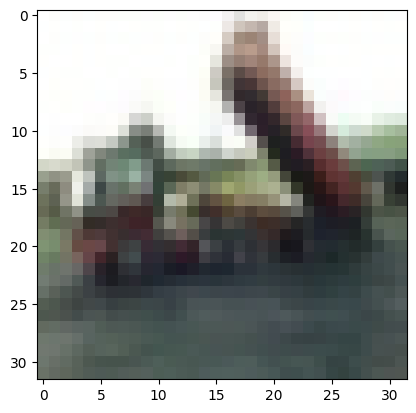

In [4]:
plt.imshow(compressed_sample.transpose(1, 2, 0))

In [24]:
import torch
from scipy import spatial
noise1 = np.random.normal(0, 1, sample.shape)
noise2 = np.random.normal(0, 1, sample.shape)
noise_01 = (noise1.clip(-1, 1) /2 + 0.5).astype(np.float32)
noise_02 = (noise2.clip(-1, 1) /2 + 0.5).astype(np.float32)
compressed_noise1 = jpeg_compress_manual(noise_01)
compressed_noise2 = jpeg_compress_manual(noise_02)

compressed_noise_1 = (compressed_noise1 - 0.5) * 2
compressed_noise_2 = (compressed_noise2 - 0.5) * 2

print(1 - spatial.distance.cosine(noise1.flatten(), noise2.flatten()))
print(1 - spatial.distance.cosine(compressed_noise_1.flatten(), compressed_noise_2.flatten()))

0.0016842926394362578
-0.013250681432648515


In [10]:
compressed_noise_2 = (compressed_noise - 0.5) * 2
print(np.std(compressed_noise_2))

0.6114099729524106


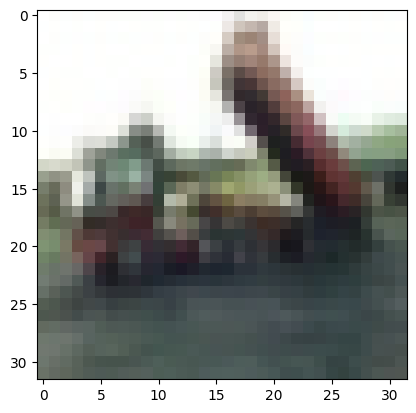

In [7]:
plt.imshow(compressed_sample.transpose(1, 2, 0))

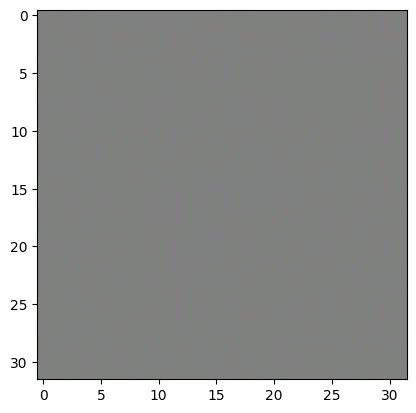

In [5]:
plt.imshow(compressed_sample.transpose(1, 2, 0))

In [208]:
print(np.sum((sample - compressed_sample1) ** 2), np.sum((sample - compressed_sample) ** 2))

1.9275356014689362 2.6700040469755493


In [212]:
import numpy as np
import cv2

# JPEG Luminance & Chrominance Quantization Tables for QF = 75
LUMINANCE_QT = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

CHROMINANCE_QT = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

LUMINANCE_QT, CHROMINANCE_QT = generate_quantization_table(50)

def apply_dct(block):
    """ Apply DCT to an 8x8 block """
    return cv2.dct(block.astype(np.float32) - 128)  # Center around zero

def apply_idct(block):
    """ Apply Inverse DCT to an 8x8 block """
    return cv2.idct(block) + 128  # Reverse centering

def jpeg_compress_manual(img_array):
    """
    Manually compresses a 3x32x32 image using JPEG-like processing.
    Optimized with vectorized operations.
    """
    # Convert to (32, 32, 3) and scale to 0-255
    img = (img_array * 255).clip(0, 255).astype(np.uint8)
    img_ycrcb = cv2.cvtColor(img.transpose(1, 2, 0), cv2.COLOR_RGB2YCrCb)

    # Create empty array for reconstructed image
    reconstructed = np.zeros_like(img_ycrcb, dtype=np.float32)

    # Vectorized processing of 8x8 blocks for each channel
    for ch, qt in enumerate([LUMINANCE_QT, CHROMINANCE_QT, CHROMINANCE_QT]):  
        # Process each channel (Y, Cr, Cb)
        for i in range(0, 32, 8):
            for j in range(0, 32, 8):
                block = img_ycrcb[i:i+8, j:j+8, ch]

                # Apply DCT
                dct_block = apply_dct(block)

                # Quantization (lossy step)
                quantized = np.round(dct_block / qt)

                # Dequantization (reconstruction)
                dequantized = quantized * qt

                # Inverse DCT
                reconstructed[i:i+8, j:j+8, ch] = apply_idct(dequantized)

    # Clip values and convert back to uint8
    reconstructed = reconstructed.clip(0, 255).astype(np.uint8)

    # Convert YCrCb → RGB
    reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_YCrCb2RGB)

    # Scale back to [0,1] and return in (3, 32, 32) format
    return reconstructed_rgb.transpose(2, 0, 1) / 255.0

# Example usage
compressed_sample = jpeg_compress_manual(sample)

print("Original shape:", sample.shape)
print("Compressed shape:", compressed_sample.shape)


Original shape: (3, 32, 32)
Compressed shape: (3, 32, 32)


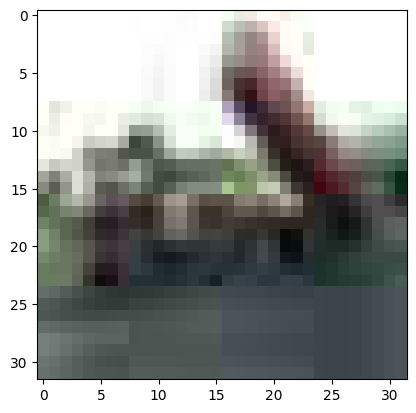

In [213]:
plt.imshow(compressed_sample.transpose(1, 2, 0))

In [214]:
print(np.sum((sample - compressed_sample1) ** 2), np.sum((sample - compressed_sample) ** 2))

1.9275356014689362 4.696639900411761


In [ ]:
import numpy as np
import cv2
lum_mean, lum_var = np.load('stats/luminance_mean.npy'), np.load('stats/luminance_var.npy')
cr_mean, cr_var = np.load('stats/chrominance_cr_mean.npy'), np.load('stats/chrominance_cr_var.npy')
cb_mean, cb_var = np.load('stats/chrominance_cb_mean.npy'), np.load('stats/chrominance_cb_var.npy')

LUMINANCE_QT, CHROMINANCE_QT_1, CHROMINANCE_QT_2 = np.load('luminance_mask.npy'), np.load('chrominance_cb_mask.npy'), np.load('chrominance_cr_mask.npy')

def apply_dct(block):
    """ Apply DCT to an 8x8 block """
    return cv2.dct(block.astype(np.float32) - 128)  # Center around zero

def apply_idct(block):
    """ Apply Inverse DCT to an 8x8 block """
    return cv2.idct(block) + 128  # Reverse centering

def dct(img_array):
    """
    Manually compresses a 3x32x32 image using JPEG-like processing.

    Args:
        img_array (np.ndarray): Input image (3, 32, 32) with values in [0,1].

    Returns:
        np.ndarray: Reconstructed image after simulated JPEG compression.
    """
    # Convert to (32, 32, 3) and scale to 0-255
    img = (img_array * 255).clip(0, 255).astype(np.uint8)
    img_ycrcb = cv2.cvtColor(img.transpose(1, 2, 0), cv2.COLOR_RGB2YCrCb)

    # Create an empty array for reconstructed image
    reconstructed = np.zeros_like(img_ycrcb, dtype=np.float32)

    # Process in 8x8 blocks
    for i in range(0, 32, 8):
        for j in range(0, 32, 8):
            for ch, qt in enumerate([(lum_mean, lum_var), (cr_mean, cr_var), (cb_mean, cb_var)]):  
                block = img_ycrcb[i:i+8, j:j+8, ch]

                # Apply DCT
                dct_block = apply_dct(block)
                
                mean, var = qt

                normalized = (dct_block - mean) / np.sqrt(var)

                # Inverse DCT
                reconstructed[i:i+8, j:j+8, ch] = normalized

    # Clip values and convert back to uint8
    # reconstructed = reconstructed.clip(0, 255).astype(np.uint8)

    # Convert YCrCb → RGB
    # reconstructed_rgb = cv2.cvtColor(reconstructed, cv2.COLOR_YCrCb2RGB)

    # Scale back to [0,1] and return in (3, 32, 32) format
    return reconstructed.transpose(2, 0, 1)

# Example usage
normalized_dct = dct(sample)



In [33]:
normalized_dcts = np.zeros(images.shape)

for i in range(len(images)):
    normalized_dcts[i] = dct(images[i])

In [56]:
np.mean(normalized_dcts[:,0,0,2])

-0.01527499220034224

(array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   2.,
          0.,   1.,   3.,   3.,   6.,   4.,   8.,   8.,  11.,  17.,  27.,
         56.,  86., 237., 266.,  77.,  55.,  30.,  21.,  23.,  12.,  12.,
         10.,   4.,   6.,   4.,   3.,   1.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-6.3 , -6.05, -5.8 , -5.55, -5.29, -5.04, -4.79, -4.54, -4.29,
        -4.03, -3.78, -3.53, -3.28, -3.03, -2.78, -2.52, -2.27, -2.02,
        -1.77, -1.52, -1.26, -1.01, -0.76, -0.51, -0.26, -0.01,  0.25,
         0.5 ,  0.75,  1.  ,  1.25,  1.51,  1.76,  2.01,  2.26,  2.51,
         2.76,  3.02,  3.27,  3.52,  3.77,  4.02,  4.28,  4.53,  4.78,
         5.03,  5.28,  5.53,  5.79,  6.04,  6.29]),
 <BarContainer object of 50 artists>)

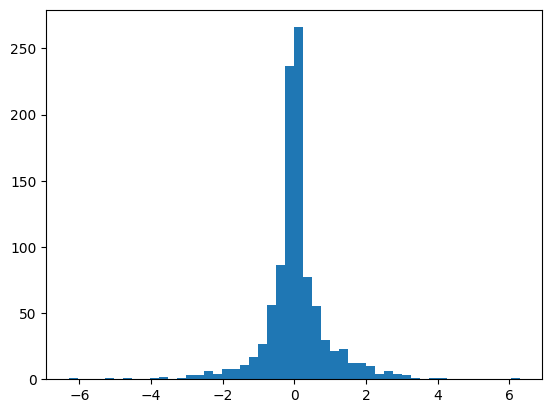

In [54]:
import matplotlib.pyplot as plt

plt.hist(normalized_dcts[:,0,0,3], bins=50)

In [42]:
normalized_dcts[:,1,0,0].max()

9.192096710205078

(array([  2.,   1.,   1.,   0.,   1.,   1.,   0.,   3.,   3.,   2.,   2.,
          7.,  12.,  14.,  12.,  26.,  27.,  35.,  43.,  47.,  75.,  60.,
         91., 103., 132.,  73.,  37.,  32.,  30.,  24.,  12.,  24.,  13.,
         10.,  12.,   7.,   3.,   5.,   6.,   1.,   4.,   1.,   2.,   1.,
          2.,   0.,   0.,   0.,   0.,   1.]),
 array([-4.31, -4.12, -3.93, -3.73, -3.54, -3.35, -3.15, -2.96, -2.77,
        -2.57, -2.38, -2.19, -1.99, -1.8 , -1.61, -1.41, -1.22, -1.03,
        -0.83, -0.64, -0.45, -0.25, -0.06,  0.13,  0.33,  0.52,  0.71,
         0.91,  1.1 ,  1.29,  1.49,  1.68,  1.87,  2.07,  2.26,  2.45,
         2.65,  2.84,  3.03,  3.22,  3.42,  3.61,  3.8 ,  4.  ,  4.19,
         4.38,  4.58,  4.77,  4.96,  5.16,  5.35]),
 <BarContainer object of 50 artists>)

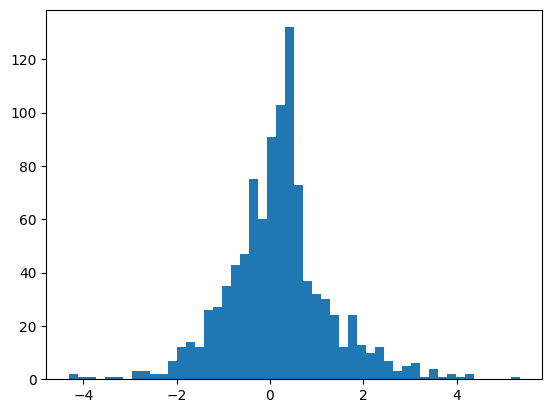

In [43]:
plt.hist(normalized_dcts[:,2,0,0], bins=50)

In [ ]:
import numpy as np

lum_mean = np.load('stats/luminance_mean.npy')
lum_var = np.load('stats/luminance_var.npy')
cb_mean = np.load('stats/chrominance_cb_mean.npy')
cb_var = np.load('stats/chrominance_cb_var.npy')
cr_mean = np.load('stats/chrominance_cr_mean.npy')
cr_var = np.load('stats/chrominance_cr_var.npy')

# mask True when abs(mean) < 0.01 and var < 0.07
luminance_mask = (np.abs(lum_mean) < 0.01) & (lum_var < 0.07)
chrominance_cb_mask = (np.abs(cb_mean) < 0.01) & (cb_var < 0.07)
chrominance_cr_mask = (np.abs(cr_mean) < 0.01) & (cr_var < 0.07)

In [ ]:
import numpy as np

# Load data
lum_mean = np.load('stats/luminance_mean.npy')
lum_var = np.load('stats/luminance_var.npy')
cb_mean = np.load('stats/chrominance_cb_mean.npy')
cb_var = np.load('stats/chrominance_cb_var.npy')
cr_mean = np.load('stats/chrominance_cr_mean.npy')
cr_var = np.load('stats/chrominance_cr_var.npy')


# Compute masks (ensure element-wise operations)
luminance_mask = (np.abs(lum_mean) < 0.01) & (lum_var < 0.7)
chrominance_cb_mask = (np.abs(cb_mean) < 0.01) & (cb_var < 0.7)
chrominance_cr_mask = (np.abs(cr_mean) < 0.01) & (cr_var < 0.7)

# Print some info for debugging
print(f"Luminance mask: {luminance_mask.sum()} / {luminance_mask.size} true values")
print(f"Chrominance CB mask: {chrominance_cb_mask.sum()} / {chrominance_cb_mask.size} true values")
print(f"Chrominance CR mask: {chrominance_cr_mask.sum()} / {chrominance_cr_mask.size} true values")


Luminance mask: 0 / 64 true values
Chrominance CB mask: 11 / 64 true values
Chrominance CR mask: 11 / 64 true values


In [ ]:
# save masks
# np.save('luminance_mask2.npy', luminance_mask)
# np.save('chrominance_cb_mask2.npy', chrominance_cb_mask)
# np.save('chrominance_cr_mask2.npy', chrominance_cr_mask)